# SpecUFEx Tutorial: The Geysers, California

Written by Theresa Sawi and Nate Groebner

Based on the study **Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field** by Holtzman et al., 2018. DOI 10.1126/sciadv.aao2929

This example walks through fitting a SpecUFEx model to seismograms of approximately 5,000 microearthquakes from The Geysers geothermal field in California from 2012 to 2014. This is a subset of the 46,000 events that were analyzed in the study above. Using the features extracted by SpecUFEx, k-means clustering identifies 4 clusters of earthquake patterns that are correlated to rate of water flow into the injection wells.

## Tutorial Steps

1. Read in waveforms from hdf5 file.
2. Convert waveforms to spectrograms (filtered and median normalized)
3. Run SpecUFEx on spectrograms: Nonnegative matrix factorization followed by hidden markov model
4. Do kmeans clustering on SpecUFEx fingerprints
5. Compare clusters to paper figure 3c



### Imports

In [1]:
import datetime
from datetime import datetime
import glob
import os
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from io import StringIO
import scipy.signal as sp
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import trange
import obspy
from specufex import BayesianNonparametricNMF, BayesianHMM
import tqdm
from sklearn.metrics import silhouette_samples
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap


# Define functions

In [2]:





def calcSilhScore(X,range_n_clusters):
    """
    Calculates the optimal number of clusters and silhouette scores for K-means clustering.

    Parameters:
    -----------
    X : array-like
        The input dataset to be clustered.
    range_n_clusters : list or range
        A range of integers specifying the number of clusters to evaluate.

    Returns:
    --------

    ## Return avg silh scores, avg SSEs, and Kopt for 2:Kmax clusters
    ## Returns altered cat00 dataframe with cluster labels and SS scores,
    ## Returns NEW catall dataframe with highest SS scores

    Kopt : int
        The optimal number of clusters.
    maxSilScore : float
        The maximum silhouette score achieved.
    avgSils : list
        A list of average silhouette scores for each number of clusters.
    sse : list
        A list of sum of squared errors for each number of clusters.
    cluster_labels_best : array-like
        cluster labels for the best clustering result.
    ss_best : array-like
        Silhouette scores for each sample in the best clustering result.
    euc_dist_best : array-like
        Euclidean distances to the centroids for each sample in the best clustering result.
    """





## alt. X = 'PCA'

    maxSilScore = 0

    sse = []
    avgSils = []
    centers = []

    for n_clusters in range_n_clusters:

        print(f"kmeans on {n_clusters} clusters...")

        kmeans = KMeans(n_clusters=n_clusters,
                           max_iter = 500,
                           init='k-means++', #how to choose init. centroid
                           n_init=10, #number of Kmeans runs
                           random_state=0) #set rand state

        #get cluster labels
        cluster_labels_0 = kmeans.fit_predict(X)

        #increment labels by one to match John's old kmeans code
        cluster_labels = [int(ccl)+1 for ccl in cluster_labels_0]

        #get euclid dist to centroid for each point
        sqr_dist = kmeans.transform(X)**2 #transform X to cluster-distance space.
        sum_sqr_dist = sqr_dist.sum(axis=1)
        euc_dist = np.sqrt(sum_sqr_dist)

        #save centroids
        centers.append(kmeans.cluster_centers_ )

        #kmeans loss function
        sse.append(kmeans.inertia_)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

#         %  Silhouette avg
        avgSil = np.mean(sample_silhouette_values)

        # avgSil = np.median(sample_silhouette_values)

        avgSils.append(avgSil)
        if avgSil > maxSilScore:
            Kopt = n_clusters
            maxSilScore = avgSil
            cluster_labels_best = cluster_labels
            euc_dist_best = euc_dist
            ss_best       = sample_silhouette_values


    print(f"Best cluster: {Kopt}")



    return Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best


def getSgram(evID,SpecUFEx_H5_path):


    with h5py.File(SpecUFEx_H5_path,'r') as fileLoad:

        sgram = fileLoad['spectrograms'].get(str(evID))[:]
        fSTFT = fileLoad['spectrograms/fSTFT'][()]
        tSTFT = fileLoad['spectrograms/tSTFT'][()]
       
    
    return tSTFT, fSTFT, sgram


# Set Param

In [3]:
numEx = 5
wf_H5_path = "./data/amatrice/waveforms_respremoved_1000.h5"
SpecUFEx_H5_path = './data/amatrice/SpecUFEx_waveforms_respremoved_1000.h5'


# bandpass filter for spectrogram
fMin = 5 # Hz
fMax = 20 #Hz 150 orig

# spectrogram parameters
sgramMode='magnitude'
sgramScaling='spectrum'

# frequency/time resolution
nperseg = 64
noverlap = nperseg/4
nfft = 512


#SpecuFEx params
num_states = 15


## Load H5

In [4]:
# ! curl "" -O "./data/amatrice/"

In [5]:
with h5py.File(wf_H5_path, "r") as h5fi:


    waveforms = h5fi["waveform"][()]
    event_ids = h5fi["event_ID"][()]       
    otime = h5fi["otime"][()]   
    lat = h5fi["lat"][()] 
    lon = h5fi["lon"][()] 
    mag = h5fi["mag"][()]     
    depth = h5fi["depth"][()]     
    fs = h5fi["sampling_rate"][()]  # Hz, sampling rate

    
  


In [6]:


cat = pd.DataFrame({'event_ID':event_ids,
                    'lat':lat,
                    'lon':lon,
                    'depth':depth,
                    'mag':mag,                    
                    'otime': otime})

cat['event_ID'] = [f.decode('utf-8') for f in cat['event_ID']]


cat['otime'] = [datetime.strptime(f.decode('utf-8'), '%Y-%m-%d %H:%M:%S.%f') for f in cat['otime']]
cat['waveform'] = list(waveforms)

cat

,event_ID,lat,lon,depth,mag,otime,waveform
0,100002,42.7523,13.1802,3.04,-0.78,2016-10-13 00:00:06.340,"[4.2243607469401114e-10, 4.062518283745035e-10..."
1,100007,42.8697,13.0733,1.82,0.32,2016-10-13 00:01:34.430,"[-4.161164062285241e-10, -4.3308143399426666e-..."
2,100008,42.6430,13.2463,8.08,-0.31,2016-10-13 00:02:23.000,"[8.48574001873357e-10, 5.627940091035957e-11, ..."
3,100037,42.8095,13.2003,3.57,-0.22,2016-10-13 00:13:51.200,"[3.980581446535858e-09, -2.4276266300034087e-0..."
4,100044,42.6847,13.2170,7.88,0.05,2016-10-13 00:15:53.610,"[-3.0818493229896635e-09, 2.1899228617786262e-..."
...,...,...,...,...,...,...,...
991,116395,42.8197,13.1870,2.82,-0.14,2016-10-18 23:16:06.170,"[8.848656920023287e-09, -7.835544594781829e-11..."
992,116400,42.8067,13.0865,5.50,0.04,2016-10-18 23:17:57.580,"[8.844901005002873e-09, 1.606260378612245e-08,..."
993,116439,42.8502,13.1568,4.40,0.03,2016-10-18 23:34:15.060,"[7.398350205050709e-09, 2.373064627032571e-09,..."
994,116445,42.8243,13.0503,3.32,-0.13,2016-10-18 23:36:16.650,"[1.4101517337333794e-09, 2.993863540435694e-08..."


## Create spectrograms

### Set spectrogram parameters 

These parameters control spectrogram generation. Two parameters, fs (sampling rate) and len_data (number of samples of a waveform) depend on the data themselves. All waveforms must have the same number of samples. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html for more information about the parameters.

In [7]:
# waveform parameters
len_data = len(cat["waveform"].iloc[0])


### Calculate spectrograms and convert to dB

The NMF algorithm requires that all spectrograms contain nonnegative values. The following procedure normalizes each spectrogram individually and ensures element-wise nonnegativity.

Calculate raw spectrograms using scipy:

In [8]:
fSTFT, tSTFT, STFT_raw = sp.spectrogram(
    x=np.stack(cat["waveform"].values),
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    nfft=nfft,
    scaling=sgramScaling,
    axis=-1,
    mode=sgramMode
)

Quality check to see if any elements are NaN.

In [9]:
np.isnan(STFT_raw).any()

False

*Optional step*: Select a frequency band from the spectrograms

Some applications benefit from discarding low and/or high frequency data from the spectrograms, e.g. if there is significant high frequency noise. The following applies a bandpass filter to the data in the frequency domain.

In [10]:
freq_slice = np.where((fSTFT >= fMin) & (fSTFT <= fMax))
fSTFT   = fSTFT[freq_slice]
STFT_0 = STFT_raw[:,freq_slice,:].squeeze()

Next, we normalize each spectrogram by its median and convert to dB. This creates a matrix where about half of the nonzero entries are negative and half are positive. All of the negative entries are then set to zero, ensuring that the NMF algorithm has valid, nonnegative data. It also has the effect of throwing away half of the data, the half that is below the median dB value. 

In [11]:
normConstant = np.median(STFT_0, axis=(1,2))
STFT_norm = STFT_0 / normConstant[:,np.newaxis,np.newaxis]  # norm by median
del STFT_0
STFT_dB = 20*np.log10(STFT_norm, where=STFT_norm != 0) # convert to dB
del STFT_norm
STFT = np.maximum(0, STFT_dB) # make sure nonnegative
del STFT_dB

cat["stft"] = list(STFT)
cat.head()

,event_ID,lat,lon,depth,mag,otime,waveform,stft
0,100002,42.7523,13.1802,3.04,-0.78,2016-10-13 00:00:06.340,"[4.2243607469401114e-10, 4.062518283745035e-10...","[[4.82617167750785, 0.0, 0.0, 0.0, 2.451006879..."
1,100007,42.8697,13.0733,1.82,0.32,2016-10-13 00:01:34.430,"[-4.161164062285241e-10, -4.3308143399426666e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,100008,42.6430,13.2463,8.08,-0.31,2016-10-13 00:02:23.000,"[8.48574001873357e-10, 5.627940091035957e-11, ...","[[0.39380922199889445, 4.536511501270216, 4.42..."
3,100037,42.8095,13.2003,3.57,-0.22,2016-10-13 00:13:51.200,"[3.980581446535858e-09, -2.4276266300034087e-0...","[[2.0045813306918308, 0.6775345700161346, 0.0,..."
4,100044,42.6847,13.2170,7.88,0.05,2016-10-13 00:15:53.610,"[-3.0818493229896635e-09, 2.1899228617786262e-...","[[0.0, 0.0, 1.9642720816366577, 0.0, 0.0, 0.0,..."


Another quality check.

In [12]:
bad_idx = cat["stft"][cat["stft"].apply(lambda x: np.isnan(x).any())].index
print(f"Bad spectrograms: \n{cat.loc[bad_idx].event_ID}")
cat = cat.drop(bad_idx).sort_values("event_ID")

Bad spectrograms: 
Series([], Name: event_ID, dtype: object)


Plotted below is a raw spectrogram and its normalized counterpart. Notice how the overall dynamic range of spectrogram is compressed.

Text(0.5, 1.0, 'Normalized spectrogram')

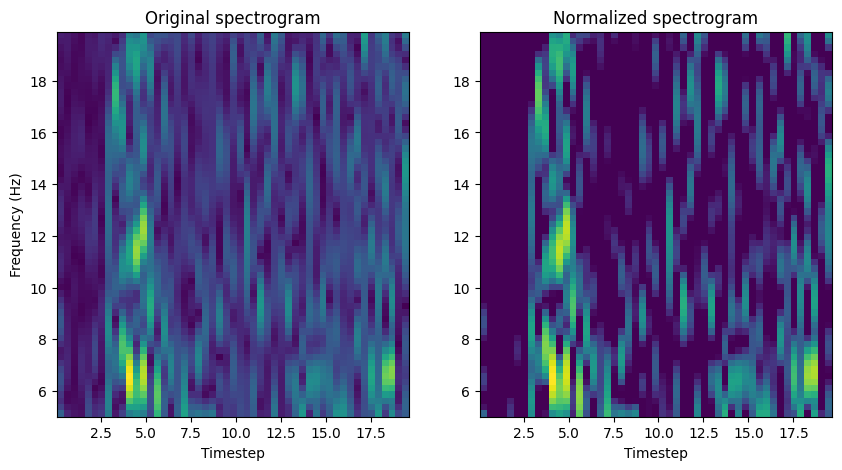

In [13]:
n_spectrogram = 0 # index of spectrogram to plot

f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].pcolormesh(tSTFT,fSTFT,STFT_raw[n_spectrogram,freq_slice,:].squeeze())
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title("Original spectrogram")

ax[1].pcolormesh(tSTFT,fSTFT, STFT[n_spectrogram])
ax[1].set_xlabel("Timestep")
ax[1].set_title("Normalized spectrogram")


# Run specufex

## Fitting models and transforming data

SpecUFEx fits a group of spectrograms, where D is the number of rows (frequency bands) and M is the number of columns (timesteps) in each spectrogram. The spectrograms must be in a numpy-compatible matrix of dimension, N being the number of spectrograms in the dataset. Each spectrogram must consist of all nonnegative (>=0) entries

The two main classes in this package are `BayesianNonparametricNMF` and `BayesianHMM`. Each has fit, transform, and fit_transform methods to be consistent with the Scikit-learn API style.

### Probabilistic nonegative matrix factorization

The first step in the specufex algorithm is to decompose the set of spectrograms into a single, common "dictionary" matrix and a set of "activation matrices", one for each spectrogram. The `BayesianNonParametricNMF` class implements a probabilistic hierarchical Bayesian model for estimating this decomposition.

First instantiate the nmf model. The constructor takes a tuple with the dimensions of the spectrogram matrix.

In [14]:
nmf = BayesianNonparametricNMF(np.stack(cat["stft"].values).shape)

The model is fit in a loop. In our case, we use 100,000 batches with batch size of 1.

In [15]:
batches = 1000
batch_size = 1

t = trange(batches, desc="NMF fit progress ", leave=True)
for i in t:
    idx = np.random.randint(len(cat["stft"].values), size=batch_size)
    nmf.fit(cat["stft"].iloc[idx].values)
    t.set_postfix_str(f"Patterns: {nmf.num_pat}")

NMF fit progress : 100%|██████| 1000/1000 [00:12<00:00, 79.02it/s, Patterns: 12]


The estimated dictionary matrix is plotted below.

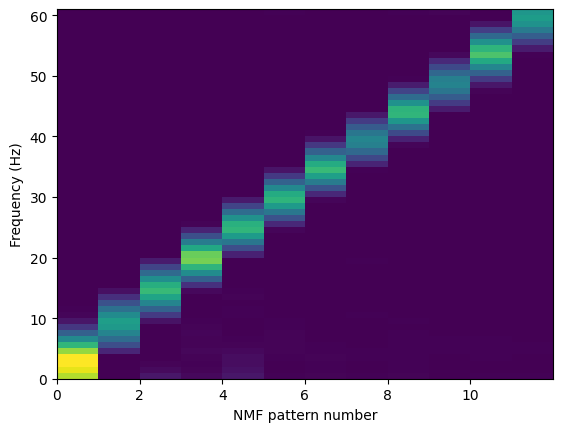

In [16]:
plt.pcolormesh(nmf.EW@np.diag(nmf.EA[0]))
plt.xlabel("NMF pattern number")
plt.xticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
plt.ylabel("Frequency (Hz)")
plt.show()

Next, the `transform` method of the` BayesianNonparametricNMF` class is used to find the activation matrices, Vs, for each spectrogram.

In [17]:
Vs = nmf.transform(cat["stft"].values)
# save Vs to an hdf5
with h5py.File("data/geysers/Vs.h5", "w") as f:
    f["Vs"] = Vs


Here is an example activation matrix, plotted with the corresponding original normalized matrix.

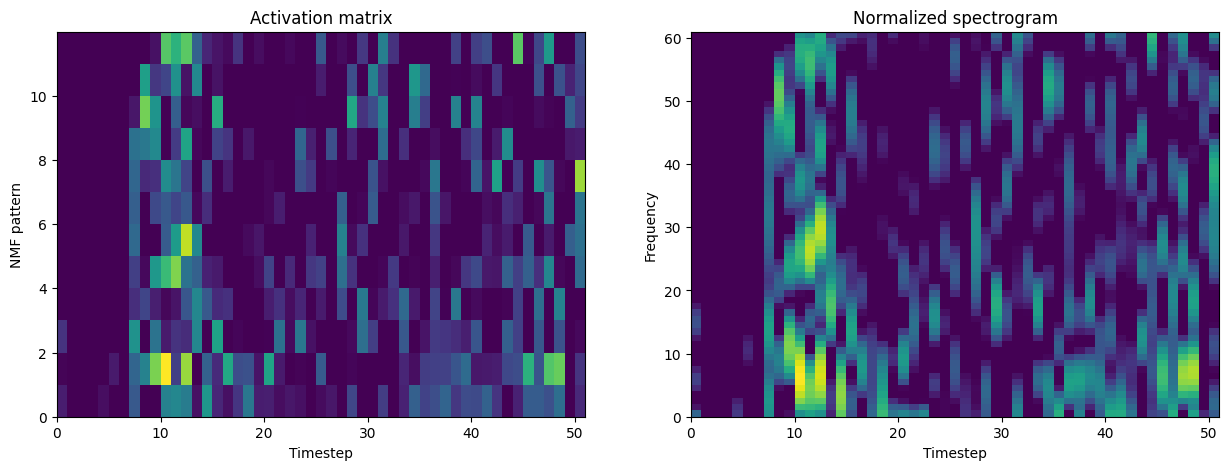

In [18]:
f, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].pcolormesh(Vs[0])
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("NMF pattern")
axes[0].set_yticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
axes[0].set_title("Activation matrix")

axes[1].pcolormesh(cat["stft"].iloc[0])
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Normalized spectrogram")

plt.show()

### Probabilistic Hidden Markov Model

A hidden Markov model describes a system where a sequence of observations is produced by hidden, or unobservable, states. In our case, the frequency components of each timestep in a spectrogram is assumed to be emitted with a particular probability by one of the hidden states. The code fits an HMM model to the spectrograms, and for each timestep calculates the most probable hidden state that produced the frequency pattern.

The HMM model is created using the `BayesianHMM` class. Currently, in order to setup the object correctly the number of NMF patterns (num_pat) and the gain calculated by `BayesianNonparametricNMF` are passed to the constructor. Similar to the NMF calculation, the data are transformed to fingerprints with the transform function.

In [19]:
#nmf = BayesianNonparametricNMF.load("data/geysers/nmf.h5")

hmm = BayesianHMM(nmf.num_pat, nmf.gain, num_state=num_states, Neff=1000)

In [20]:
batches = 1000
t = trange(batches, desc="HMM fit progress ", leave=True)
for i in t:
    idx = np.random.randint(Vs.shape[0], size=1)
    hmm.fit(Vs[idx])


HMM fit progress : 100%|████████████████████| 1000/1000 [00:33<00:00, 29.45it/s]


The *emmission matrix* of the HMM relates the hidden state to the expected value of each frequency emitted by that state. Below is the calculated emmissions matrix for our model.

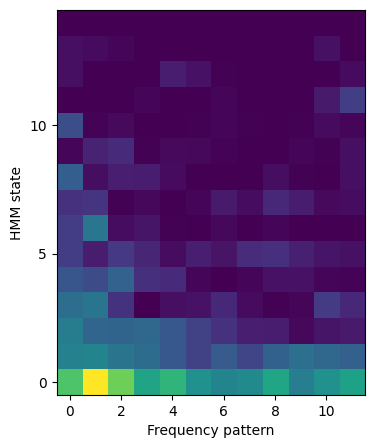

In [21]:
plt.figure(figsize=(10,5))
plt.imshow(hmm.EB, origin="lower")
plt.ylabel("HMM state")
plt.xlabel("Frequency pattern")
_=plt.yticks(range(0,num_states,5), range(0, num_states,5))

Next step is to calculate the "fingerprints", which are the final features calculated by the SpecUFEx algorithm. ?The fingerprints are a statistical representation of how likely each state transition is for each individual spectrogram.

Below, the `.transform()` method is used to calculate the fingerprints. It also returns a state transition count matrix (`As`) and the state sequence matrix (`gams`).

In [22]:
fingerprints, As, gams = hmm.transform(Vs)

Example of a fingerprint. Each entry in the matrix is the probability that, for the corresponding spectrogram, a given state transitions to another state.

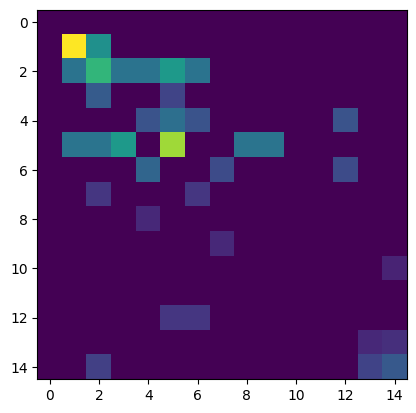

In [23]:
plt.imshow(fingerprints[0])

And this is the state transition matrix. This is the actual temporal order of probabilities that the system was in a given state when it emitted the frequencies.

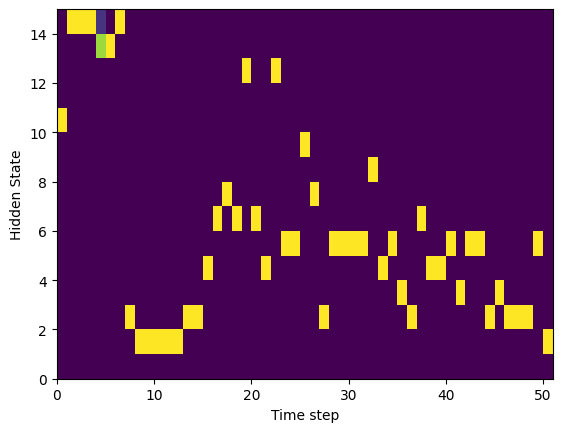

In [24]:
plt.pcolormesh(gams[0])
plt.xlabel("Time step")
plt.ylabel("Hidden State")
plt.show()

# Save to H5


In [25]:

####################################################################################
####################################################################################
###
### save output to H5
###
####################################################################################
####################################################################################


print('writing all output to h5')
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:


    ##fingerprints are top folder
    if 'fingerprints' in fileLoad.keys():
        del fileLoad["fingerprints"]
    fp_group = fileLoad.create_group('fingerprints')

    if 'SpecUFEX_output' in fileLoad.keys():
        del fileLoad["SpecUFEX_output"]
    out_group = fileLoad.create_group("SpecUFEX_output")

    if 'spectrograms' in fileLoad.keys():
        del fileLoad["spectrograms"]
    sp_group = fileLoad.create_group("spectrograms")    

    
    # write fingerprints: ===============================
    for i, evID in enumerate(cat.event_ID):
        fp_group.create_dataset(name= evID, data=fingerprints[i])

    # write the spectrograms: ===========================    
    
    for i, evID in enumerate(cat.event_ID):
        sp_group.create_dataset(name= evID, data=cat["stft"].iloc[i])

    sp_group.create_dataset(name='fSTFT',data=fSTFT)
    sp_group.create_dataset(name='tSTFT',data=tSTFT)
    sp_group.create_dataset(name='nperseg',data=nperseg)
    sp_group.create_dataset(name='noverlap',data=noverlap)
    sp_group.create_dataset(name='nfft',data=nfft)
    sp_group.create_dataset(name='sgramScaling',data=sgramScaling)
    sp_group.create_dataset(name='sgramMode',data=sgramMode)

    # write the SpecUFEx out: ===========================
    # maybe include these, but they are not yet tested.
    ACM_group = fileLoad.create_group("SpecUFEX_output/ACM")
    STM_group = fileLoad.create_group("SpecUFEX_output/STM")

    for i, evID in enumerate(cat.event_ID):
        ACM_group.create_dataset(name=evID,data=Vs[i]) #ACM
        STM_group.create_dataset(name=evID,data=gams[i]) #STM

    gain_group = fileLoad.create_group("SpecUFEX_output/ACM_gain")
    W_group                      = fileLoad.create_group("SpecUFEX_output/W")
    EB_group                     = fileLoad.create_group("SpecUFEX_output/EB")
    ## # # delete probably ! gain_group                   = fileLoad.create_group("SpecUFEX_output/gain")
    #RMM_group                    = fileLoad.create_group("SpecUFEX_output/RMM")

    W_group.create_dataset(name='W',data=nmf.EW)
    EB_group.create_dataset(name=evID,data=hmm.EB)
    gain_group.create_dataset(name='gain',data=nmf.gain) #same for all data
    # RMM_group.create_dataset(name=evID,data=RMM)
    






writing all output to h5


# cluster fingerprints with Kmeans

The SpecUFEx procedure reduces a set of waveforms/spectrograms to a set of feature matrices. These features can then be used as input to a machine learning algorithm. In this example, we use the features for unsupervised clustering of similar fingerprints.


In [26]:
# convert fingerprints from 2D array to 1D array
fingerprints_ = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))

#Predicted labels
min_num_cluster = 3
max_num_cluster = 20

range_n_clusters = range(min_num_cluster,max_num_cluster)
Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(fingerprints_,range_n_clusters)

cat['cluster'] = cluster_labels_best
cat['SS'] = ss_best


kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
kmeans on 11 clusters...
kmeans on 12 clusters...
kmeans on 13 clusters...
kmeans on 14 clusters...
kmeans on 15 clusters...
kmeans on 16 clusters...
kmeans on 17 clusters...
kmeans on 18 clusters...
kmeans on 19 clusters...
Best cluster: 5


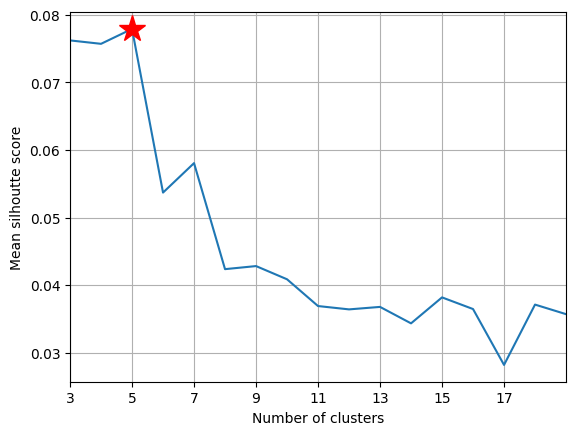

In [27]:
axSS = plt.gca()
axSS.plot(range_n_clusters,avgSils)
axSS.plot(Kopt,avgSils[Kopt-min_num_cluster],'r*',ms=20)
axSS.set_xlabel('Number of clusters')
axSS.set_ylabel('Mean silhoutte score')
axSS.set_xticks(range(min(range_n_clusters),max(range_n_clusters),2));

# axSS.set_ylim(.1,.4)
axSS.set_xlim(min(range_n_clusters),max(range_n_clusters))

axSS.grid()
    


# Plot clusters over time (2012-2014)


We now compare the clusters from our fit to the results from the reference above. The following code plots the frequency of earthquakes in each cluster over time.

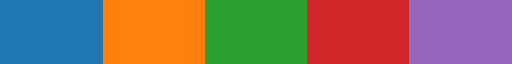

In [28]:

# List of 12 distinct colors
colors_all = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',  '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#FF5733', '#33FF57']  # Add more colors as needed

# Create a ListedColormap object
cmap1 = ListedColormap(colors_all[:Kopt])
cmap1


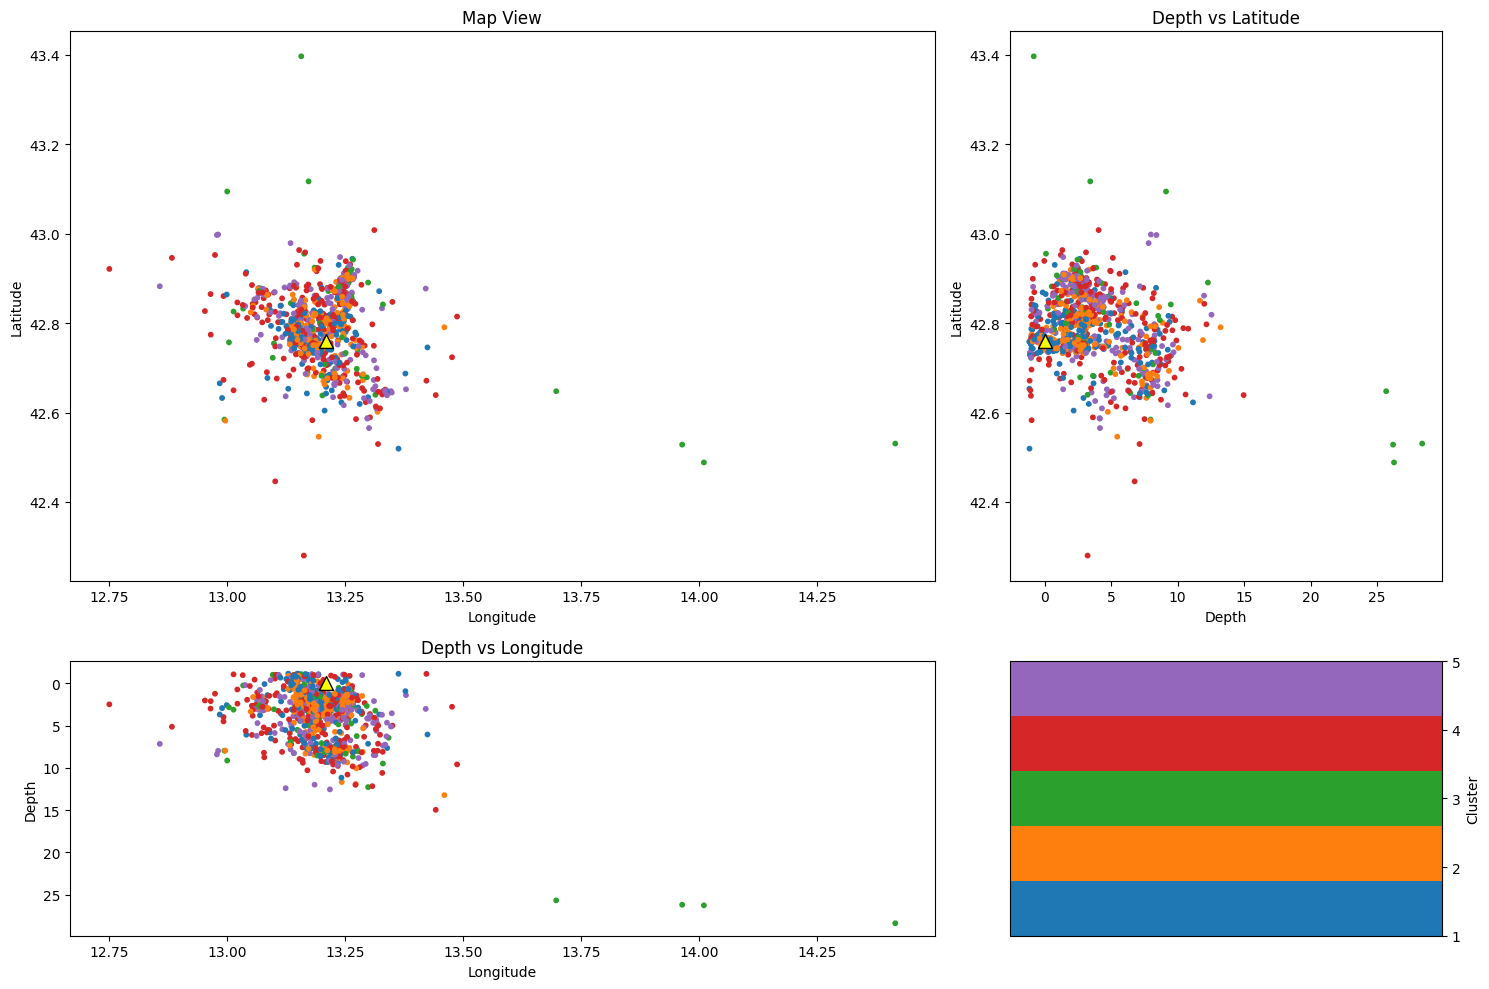

In [29]:
import matplotlib.gridspec as gridspec

station_lon, station_lat = 13.208697, 42.759537
depth = cat["depth"].values
lon = cat["lon"].values
lat = cat["lat"].values
cluster = cat["cluster"].values

# Create a figure and a grid layout
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])


# Map view
ax1 = plt.subplot(gs[0])
im1 = ax1.scatter(lon, lat, c=cluster, cmap=cmap1, s=10)
ax1.scatter(station_lon, station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Map View')

# Depth vs Latitude
ax2 = plt.subplot(gs[1])
im2 = ax2.scatter( depth,lat,c=cluster, cmap=cmap1, s=10)
ax2.scatter(0,station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Depth')
ax2.set_title('Depth vs Latitude')

# Depth vs Longitude
ax3 = plt.subplot(gs[2])
im3 = ax3.scatter(lon, depth, c=cluster, cmap=cmap1, s=10)
ax3.scatter(station_lon, 0, color='yellow', s=100, edgecolor='k', marker='^')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Depth')
ax3.set_title('Depth vs Longitude')
ax3.invert_yaxis()


cbar_ax1= plt.subplot(gs[3])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label('Cluster')
cbar1.set_ticks(np.arange(1, Kopt+1))  # Set colorbar ticks to integers 1 through 4

# # Add colorbars
# cbar_ax1 = fig.add_axes([0.45, 0.53, 0.02, 0.35])  # Position for colorbar 1
# cbar_ax2 = fig.add_axes([0.92, 0.53, 0.02, 0.35])  # Position for colorbar 2
# cbar_ax3 = fig.add_axes([0.45, 0.1, 0.47, 0.02])   # Position for colorbar 3

# cbar2 = fig.colorbar(im2, cax=cbar_ax2)
# cbar3 = fig.colorbar(im3, cax=cbar_ax3)
# cbar2.set_label('Cluster')
# cbar3.set_label('Cluster')

plt.tight_layout()
plt.show()


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 78.04it/s]


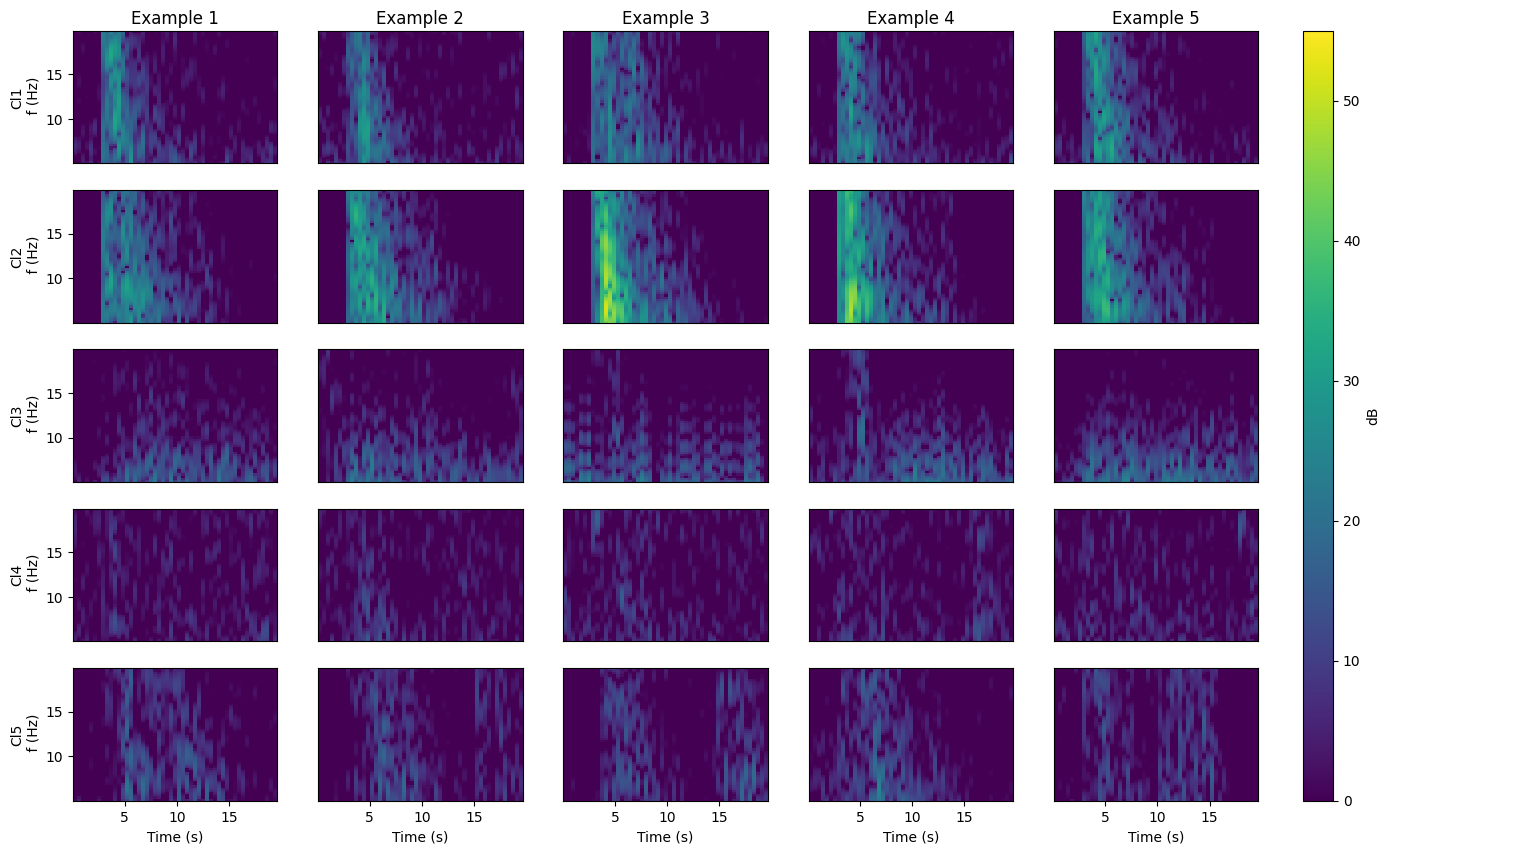

In [30]:

####################################################################################
####################################################################################
###
### Figure 3. Plot spectrogram examples
###
####################################################################################
####################################################################################

fig = plt.figure(figsize=(15,10))

gs = GridSpec(nrows=Kopt, ncols=numEx, left=0.1, right=0.89)#, width_ratios=[1, 2], height_ratios=[4, 1])
gs2 = GridSpec(nrows=1, ncols=1, left=0.92, right=.94, hspace=0.05)#, width_ratios=[1, 2], height_ratios=[4, 1])


## get sgram freqs and time vectors
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    
    frequencies = fileLoad['spectrograms/fSTFT'][()]
    times =       fileLoad['spectrograms/tSTFT'][()]

    
    
for cl in range(1,Kopt+1):
    
    cat_k = cat[cat.cluster==cl].copy()
    cat_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
#         ax = axes[cl-1][i]
        ax = fig.add_subplot(gs[cl-1,i])
        
        indd = cat_k.index[i]
        
        tSTFT, fSTFT, sgram = getSgram(cat.event_ID[indd], SpecUFEx_H5_path)
        im = ax.pcolormesh(tSTFT,
                            fSTFT,
                            sgram,
                            cmap=plt.cm.viridis,
                            shading='auto',vmin=0,vmax=55)

        ax.text(len(tSTFT)-12,.8*np.max(fSTFT),f"Ml{cat_k.mag.iloc[i]}",color='white')
        

           
            
#         if i==numEx//2:
        ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n f (Hz)') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        if i!=0:
            ax.set_yticks([])
            ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5)#,fontsize=12)     

    

axcbar = fig.add_subplot(gs2[:])
cbar = plt.colorbar(im, cax=axcbar,label='dB')




# plt.savefig(pathFig + "3_" +key + "_clusterExamples_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.16it/s]


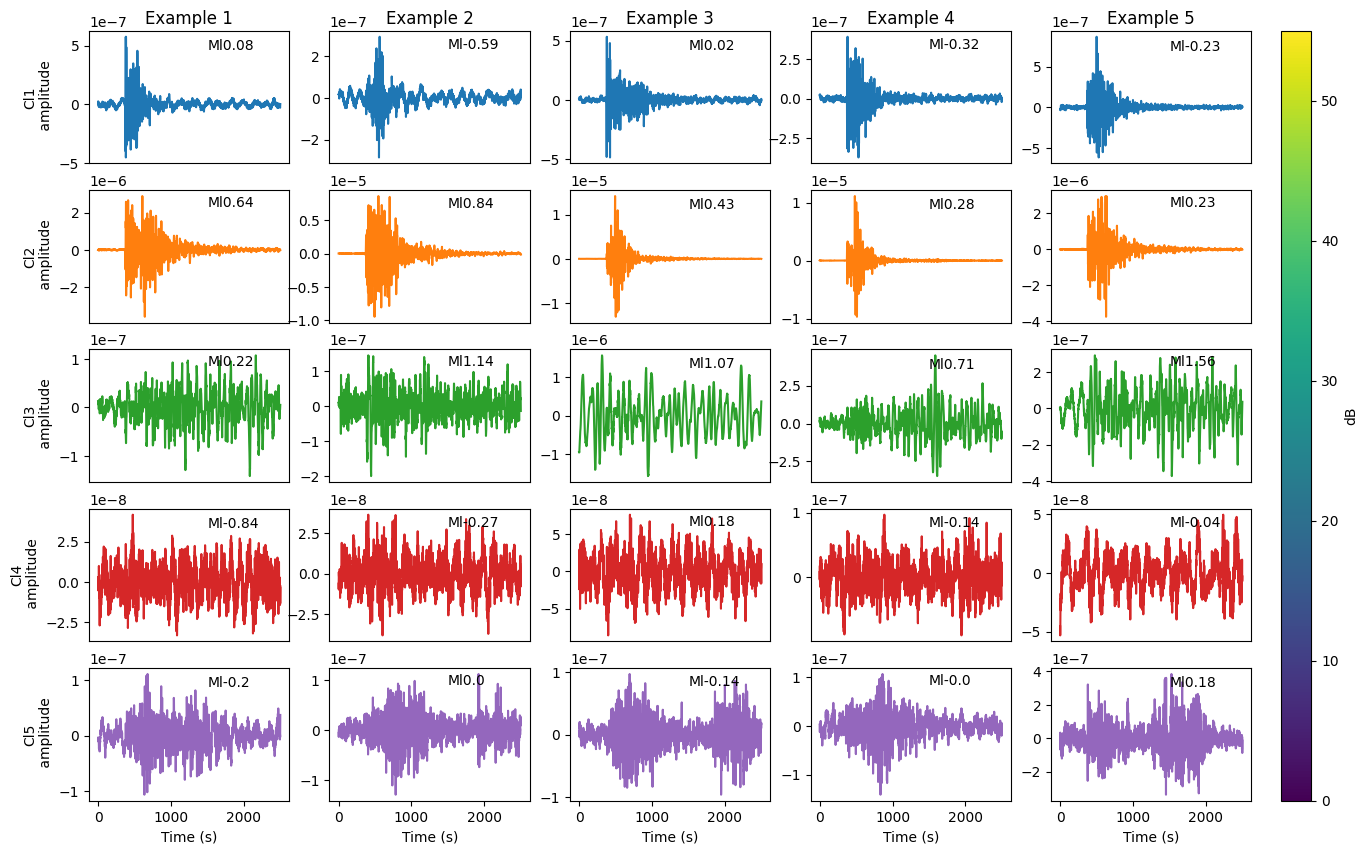

In [31]:

####################################################################################
####################################################################################
###
### Figure 3. Plot waveform examples
###
####################################################################################
####################################################################################

fig = plt.figure(figsize=(15,10))

gs = GridSpec(nrows=Kopt, ncols=numEx)#, width_ratios=[1, 2], height_ratios=[4, 1])


    
    
for cl in range(1,Kopt+1):
    
    cat_k = cat[cat.cluster==cl].copy()
    cat_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
#         ax = axes[cl-1][i]
        ax = fig.add_subplot(gs[cl-1,i])
        
        indd = cat_k.index[i]
        
        ax.plot(cat_k.waveform.iloc[i],color=colors_all[cl-1])
        ax.text(len_data-1000,.8*np.max(cat_k.waveform.iloc[i]),f"Ml{cat_k.mag.iloc[i]}")
#         if i==numEx//2:
        ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n amplitude') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        # if i!=0:
        #     ax.set_yticks([])
        #     ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5)#,fontsize=12)     

    

axcbar = fig.add_subplot(gs2[:])
cbar = plt.colorbar(im, cax=axcbar,label='dB')




# plt.savefig(pathFig + "3_" +key + "_clusterExamples_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()


<Figure size 1600x600 with 0 Axes>

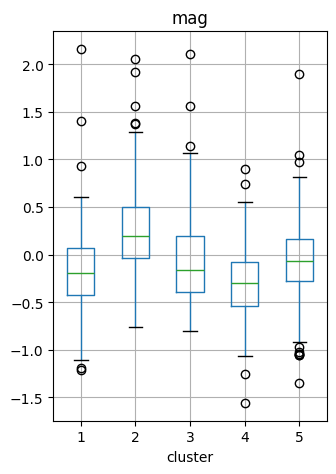

In [33]:
# Create a boxplot
plt.figure(figsize=(16, 6))
cat.boxplot(column='mag',by='cluster', layout=(1, Kopt), figsize=(15, 5))
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.title('Boxplot of Depth, Latitude, and Longitude by Cluster')
plt.tight_layout()
plt.show()

# Plot locations of 50 events in each cluster with highest SS

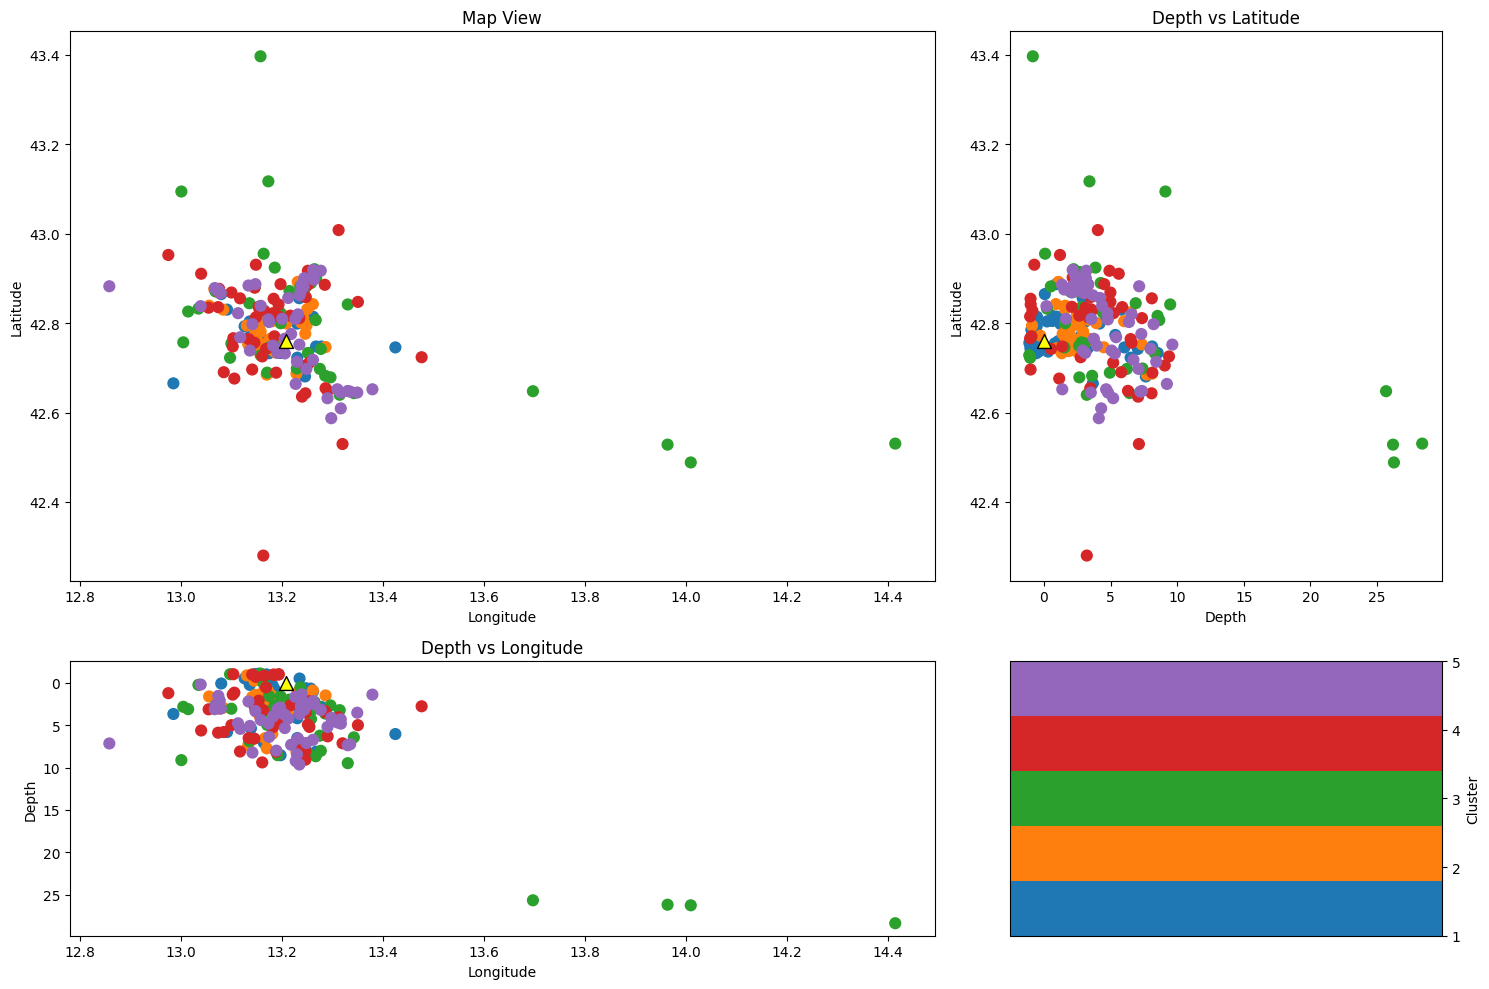

In [39]:

cat_SS = []
topF = 50
for cl in range(1,Kopt+1):
    
    cat_k = cat[cat.cluster==cl].copy()
    cat_k.sort_values(by=['SS'],ascending=[False],inplace=True)
    cat_SS.append(cat_k.iloc[0:topF])

cat_SS = pd.concat(cat_SS)


depth = cat_SS["depth"].values
lon = cat_SS["lon"].values
lat = cat_SS["lat"].values
cluster = cat_SS["cluster"].values

# Create a figure and a grid layout
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])


# Map view
ax1 = plt.subplot(gs[0])
im1 = ax1.scatter(lon, lat, c=cluster, cmap=cmap1, s=60)
ax1.scatter(station_lon, station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Map View')

# Depth vs Latitude
ax2 = plt.subplot(gs[1])
im2 = ax2.scatter( depth,lat,c=cluster, cmap=cmap1, s=60)
ax2.scatter(0,station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Depth')
ax2.set_title('Depth vs Latitude')

# Depth vs Longitude
ax3 = plt.subplot(gs[2])
im3 = ax3.scatter(lon, depth, c=cluster, cmap=cmap1, s=60)
ax3.scatter(station_lon, 0, color='yellow', s=100, edgecolor='k', marker='^')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Depth')
ax3.set_title('Depth vs Longitude')
ax3.invert_yaxis()


cbar_ax1= plt.subplot(gs[3])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label('Cluster')
cbar1.set_ticks(np.arange(1, Kopt+1))  # Set colorbar ticks to integers 1 through 4

# # Add colorbars
# cbar_ax1 = fig.add_axes([0.45, 0.53, 0.02, 0.35])  # Position for colorbar 1
# cbar_ax2 = fig.add_axes([0.92, 0.53, 0.02, 0.35])  # Position for colorbar 2
# cbar_ax3 = fig.add_axes([0.45, 0.1, 0.47, 0.02])   # Position for colorbar 3

# cbar2 = fig.colorbar(im2, cax=cbar_ax2)
# cbar3 = fig.colorbar(im3, cax=cbar_ax3)
# cbar2.set_label('Cluster')
# cbar3.set_label('Cluster')

plt.tight_layout()
plt.show()
